## **TransU-Net**




In [1]:
import numpy as np
from glob import glob

In [2]:
from tensorflow import keras

This example requires `keras-unet-collection`:
```
pip install keras-unet-collection
```

In [3]:
!pip install keras-unet-collection

     |████████████████████████████████| 71kB 9.4MB/s 


In [4]:
from keras_unet_collection import models, utils

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# file path after data extraction
path_trainval_img = "/content/drive/MyDrive/AUGdataset0/train/image/"
path_trainval_mask = "/content/drive/MyDrive/AUGdataset0/train/mask/"


In [7]:
trainval_input_names = np.array(sorted(glob(path_trainval_img+'*.jpg')))
trainval_label_names = np.array(sorted(glob(path_trainval_mask+'*.tiff')))


Training-validation data split



In [8]:
L = len(trainval_input_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.9*L); L_valid = L - L_train
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:]

train_input_names = trainval_input_names[ind_train]
train_label_names = trainval_label_names[ind_train]
valid_input_names = trainval_input_names[ind_valid]
valid_label_names = trainval_label_names[ind_valid]

print("Training:validation = {}:{}".format(L_train, L_valid))

Training:validation = 234:26


### Exploratory data analysis

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

In [10]:
i_max = 10 # explore 10 images
input_example = utils.image_to_array(train_input_names[:i_max], size=128, channel=3)
label_example = utils.image_to_array(train_label_names[:i_max], size=128, channel=1)

In [11]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt



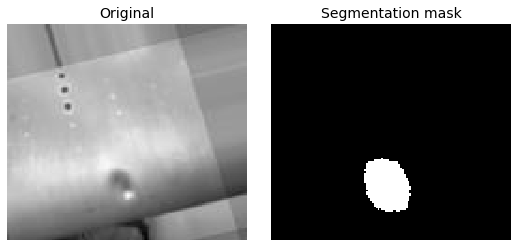

In [12]:
i_example = 2

fig, AX = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

for ax in AX:
    ax = ax_decorate_box(ax)
    
AX[0].pcolormesh(np.mean(input_example[i_example, ...], axis=-1), cmap= plt.cm.gray)
AX[1].pcolormesh(label_example[i_example, ..., 0]>0, cmap=plt.cm.binary_r)
AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Segmentation mask", fontsize=14);

In [13]:
from keras_unet_collection import models


TransU-Net pretrained with VGG16 backbone

In [14]:
model = models.transunet_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024], n_labels= 2, stack_num_down=2, stack_num_up=2,
                 embed_dim=768, num_mlp = 3072, num_heads=12, num_transformer=12,
                 activation='ReLU', mlp_activation='GELU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
                 backbone='VGG16', weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='transunet')


58892288/58889256 [==============================] - 0s 0us/step


The second layer of the configured model, i.e., right after an input layer, is expected to be the VGG16 backbone.

In [16]:
model.layers[1].name

'VGG16_backbone'

For simplicity, this segmentation model is trained with cross-entropy loss with SGD optimizer and a learning rate of 1E-2.

In [15]:
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.MeanIoU(name="meanIOU",num_classes=2),
    ]
    
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-2), metrics= METRICS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


..................


## **Training**

with 60 epoches with early stopping  Each epoch containts 10 batches and each batch contains 2 samples.

def target_data_process(target_array):
    '''Converting tri-mask of {1, 2, 3} to three categories.'''
    return keras.utils.to_categorical(target_array-1)

In [17]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    target_array[target_array>0]=1  
    return keras.utils.to_categorical(target_array, num_classes=2)

In [18]:
valid_input = input_data_process(utils.image_to_array(valid_input_names, size=128, channel=3))
valid_label = target_data_process(utils.image_to_array(valid_label_names, size=128, channel=1))

In [19]:
N_epoch = 60 # number of epoches
N_batch = 10 # number of batches per epoch
N_sample = 2 # number of samples per batch

tol = 0 # current early stopping patience
max_tol = 3 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_epoch):    
    # initial loss record
    if epoch == 0:
        y_pred =model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(utils.image_to_array(train_input_names[ind_train_shuffle], size=128, channel=3))
        train_label = target_data_process(utils.image_to_array(train_label_names[ind_train_shuffle], size=128, channel=1))
        
        # train on batch
        loss_ = model.train_on_batch([train_input,],
                                     [train_label, train_label, train_label, train_label, train_label,])
        # ** training loss is not stored ** #
        
    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #
        
    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue; 

	Initial loss = 0.2280130237340927
Validation performance 0.8741856217384338 is NOT improved
Validation performance is improved from 0.2280130237340927 to 0.20524144172668457
Validation performance is improved from 0.20524144172668457 to 0.195085346698761
Validation performance 0.19726532697677612 is NOT improved
Validation performance is improved from 0.195085346698761 to 0.18345388770103455
Validation performance 0.2320016771554947 is NOT improved
Validation performance 0.18558965623378754 is NOT improved
Validation performance 0.21565784513950348 is NOT improved
Early stopping


## Evaluation

The testing set performance is evaluated with cross-entropy and example outputs.

In [20]:
path_test_img = "/content/drive/MyDrive/AUGdataset0/test/image/"
path_test_mask = "/content/drive/MyDrive/AUGdataset0/test/mask/"

In [21]:
test_input_names = np.array(sorted(glob(path_test_img+'*.jpg')))
test_label_names = np.array(sorted(glob(path_test_mask+'*.tiff')))

In [22]:
test_input = input_data_process(utils.image_to_array(test_input_names, size=128, channel=3))
test_label = target_data_process(utils.image_to_array(test_label_names, size=128, channel=1))

In [23]:
y_pred = model.predict([test_input])

In [24]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_label, y_pred))))

Testing set cross-entropy = 0.05873808264732361


**Example of outputs**

As a common practice in computer vision projects, only nice looking samples are plotted : |

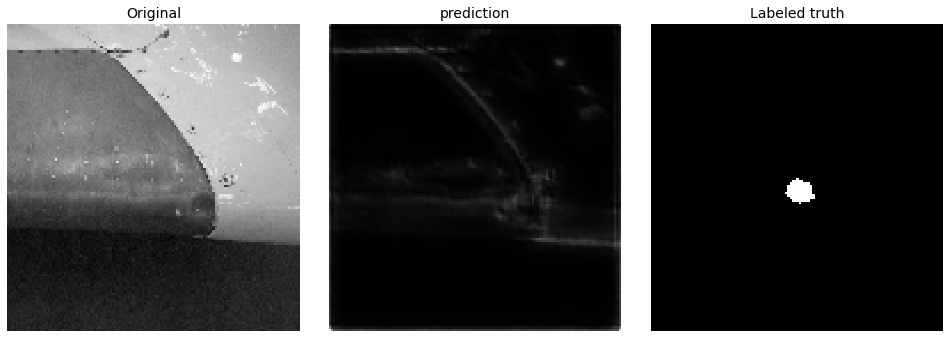

In [25]:
i_sample = 1

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ...,0], cmap=plt.cm.binary)
AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.binary)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("prediction", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);


## Discussion

A segmentation model is proposed based on the architecture of UNET 3+ and is trained using the Oxford-IIIT Pets dataset. Result evaluation indicates that this segmentation model can distinguish pixes of a pet from image backgrounds.

Many technical details of this work, for example, network hyper-parameters and training strategy, can be improved for achieving better performance. 

In [26]:
model.summary()

Model: "transunet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
VGG16_backbone (Functional)     [(None, 128, 128, 64 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
transunet_conv_trans_before (Co (None, 8, 8, 1024)   524288      VGG16_backbone[0][4]             
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 64, 1024)     0           transunet_conv_trans_before[0][0]
____________________________________________________________________________________

**Visualizing model performance**

precision recall

NameError: ignored

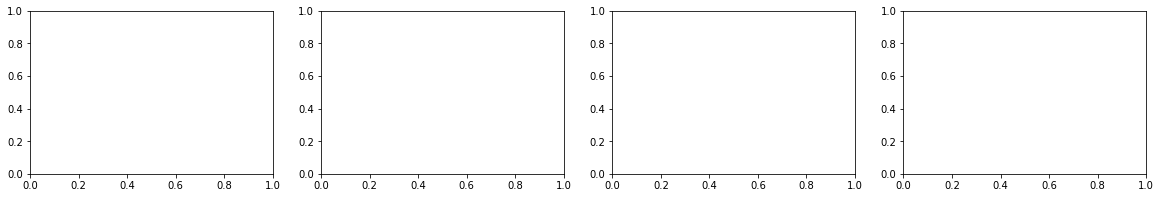

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

### **Let's evaluate the model on our test data!**

In [28]:
y_pred = model.predict([test_input])

In [29]:
model.evaluate(test_input, test_label, return_dict= True)

1/1 [==============================] - 3s 3s/step - loss: 0.0587 - binary_accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - meanIOU: 0.2500


{'binary_accuracy': 0.9887593388557434,
 'loss': 0.058738093823194504,
 'meanIOU': 0.25,
 'precision': 0.9887593388557434,
 'recall': 0.9887593388557434}

y_true	The ground truth values, with the same dimensions as y_pred. Will be cast to bool.
y_pred	The predicted values. Each element must be in the range [0, 1].
sample_weight	Optional weighting of each example. Defaults to 1. Can be a Tensor whose rank is either 0, or the same rank as y_true, and must be broadcastable to y_true.

In [30]:

m = tf.keras.metrics.Recall()
m.update_state( test_label, y_pred, sample_weight=None)
m.result().numpy()

0.98875934

In [31]:
m = tf.keras.metrics.Precision()
m.update_state( test_label, y_pred, sample_weight=None)
m.result().numpy()

0.98875934

In [32]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state( test_label, y_pred, sample_weight=None)
m.result().numpy()

0.98875934

In [36]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state( test_label, y_pred, sample_weight=None)
m.result().numpy()

0.25